In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim
from torch.autograd import grad


# Make everything double precision
#torch.set_default_tensor_type(torch.DoubleTensor)

**Motivation and problem setup**

So far in the course we have seen the model:

***propagation of Corona***
$$ S_t = -\beta SI \quad {\rm and} \quad I_t = \beta SI - \gamma I $$
where $S$ is the precent of susceptible and $I$ is percent of infected people.


For this model we have solved the dynamics (that is $S(t),I(t)$) given the initial conditions and the ODE parameters, namely $\beta$ and $\gamma$ for the SI model.

However, in reality we rarely have the "true" parameters of the ODE we are after. Therefore, it is impossible in most cases to have a predictive model before observing some real data.

We consider the data of the number of COVID dases in BC

**Loading and plotting COVID data using pandas**

We now load and plot COVID data. We use pandas for dealing with the csv file. pandas is a python package that handels many types of data. It is particularly suited to deal with text data.

In [2]:
# Open data from URL using pandas
url = 'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv'

df = pd.read_csv(url)

# This is what the data looks like
print(df)


      pruid                  prname                   prnameFR        date  \
0        59        British Columbia       Colombie-Britannique  2020-02-01   
1        48                 Alberta                    Alberta  2020-02-01   
2        47            Saskatchewan               Saskatchewan  2020-02-01   
3        46                Manitoba                   Manitoba  2020-02-01   
4        35                 Ontario                    Ontario  2020-02-01   
...     ...                     ...                        ...         ...   
2845     60                   Yukon                      Yukon  2023-09-16   
2846     61   Northwest Territories  Territoires du Nord-Ouest  2023-09-16   
2847     62                 Nunavut                    Nunavut  2023-09-16   
2848     99  Repatriated travellers        Voyageurs rapatriés  2023-09-16   
2849      1                  Canada                     Canada  2023-09-16   

      reporting_week  reporting_year  update  totalcases  numto

In [3]:
# Extract data for BC
D = df["prname"]
A = df.loc[df['prname'] == "British Columbia"]
print(A.columns)


Index(['pruid', 'prname', 'prnameFR', 'date', 'reporting_week',
       'reporting_year', 'update', 'totalcases', 'numtotal_last7',
       'ratecases_total', 'numdeaths', 'numdeaths_last7', 'ratedeaths',
       'ratecases_last7', 'ratedeaths_last7', 'numtotal_last14',
       'numdeaths_last14', 'ratetotal_last14', 'ratedeaths_last14',
       'avgcases_last7', 'avgincidence_last7', 'avgdeaths_last7',
       'avgratedeaths_last7'],
      dtype='object')


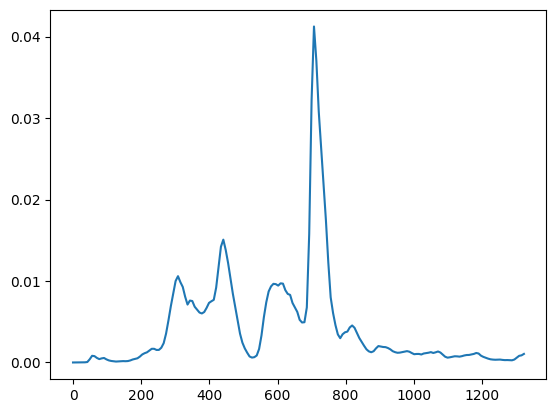

In [5]:
# Take the date column
T = A.date
# Convert it to dtype date
T = pd.to_datetime(T)
# Make it day number
base_date = T.min()
t = T.map(lambda date : (pd.Timestamp(date) - base_date).days )

# get the number of confirmed cases per day
Iobs = pd.to_numeric(A.numtotal_last14)

t = t.to_numpy()
Iobs = Iobs.to_numpy()
# Normalize S relative to exposed BC pop
Iobs = Iobs/1e6
# plot the number of active cases
plt.plot(t,Iobs)


**Comparing the data to simulation**

Now when we have the data we can compare it to the SIR model. To this end we use the simulation we generated previously. Below is the forward Euler discretization applied to the SIR model, assuming some parameters $\beta$ and $\gamma$.

Note that while we assume that $\gamma$ is fixed, $\beta$ can change. Recall that $\beta$ describes the interaction between succeptible and infected people. Such interaction can change when we apply masks or social distancing.

In [6]:
def SIRmodel(S0,I0,beta,gamma,n,dt):

  SS = torch.zeros(n+1,dtype=torch.float32)
  II = torch.zeros(n+1,dtype=torch.float32)
  t = torch.zeros(n+1,dtype=torch.float32)

  beta = torch.relu(beta)
  S = S0
  I = I0
  SS[0] = 1.0*S
  II[0] = 1.0*I
  for i in range(1,n+1):
    Sold = S
    S = S - dt*beta[i-1]*S*I
    I = (1.0 + dt*beta[i-1]*Sold - dt*gamma)*I
    t[i]  = t[i-1] + dt
    SS[i] = S
    II[i] = I

  return SS, II, t

Next we run the simulation and plot it together with the true data. We can play with parameters, namely $\beta$ and $\gamma$ to see how well we can the simulation predict the real data. You can see that it is actually quite difficult to do so when playing with the parameters manually.

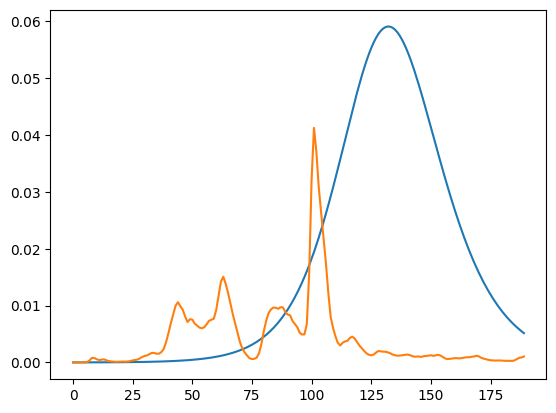

In [30]:

S0 = 0.99999
I0 = 0.00001
n  = Iobs.shape[0]

beta = 0.25*torch.ones(n,dtype=torch.float32)
gamma = 0.17
Sc, Ic, tc = SIRmodel(S0,I0,beta,gamma,n,1)

nd = Iobs.shape[0]
plt.plot(tc[:nd],Ic[:nd].detach(),tc[:nd],Iobs)

While we can predict the general trend of the first 270 days or so, we fail in predicting the rest or even smaller oscilations. To this end we will need to use a time variying $\beta$.

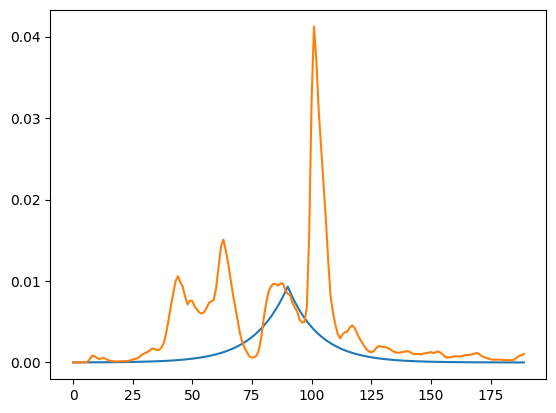

In [32]:
S0 = 0.99999
I0 = 0.00001
n  = Iobs.shape[0]

# beta
beta = 0.25*torch.ones(n,dtype=torch.float32)
# change beta after 90 days
beta[90:] = 0.1
gamma = 0.17
Sc, Ic, tc = SIRmodel(S0,I0,beta,gamma,n,1)
plt.plot(tc[:nd],Ic[:nd].detach(),tc[:nd],Iobs)

Indeed, the kink in the graph represents the time COVID regulation became much harsher.

This $\beta$ gives a general idea of what happened. To get more details we need to adjust $\beta$ such that the lines fit. This is too complicated to do manually so we turn to computerized methods of doing it.


**The basic idea of data fitting**

We have simulated (computed) data $I_c$ and we have the real data $I_{\rm obs}$. How do we know if they are similar?

This is done by introducing the idea of a loss function.
The loss function is typically small if $I_c$ and $I_{\rm obs}$ are similar. Below are a few examples of loss functions

Mean Square Error
$$ MSE = {\frac 1n} \|I_c - I_{\rm obs}\|^2 $$

$L_1$ Error
$$ MAE = {\frac 1n} \sum_n |I_{c_i} - I_{\rm obs_i}| $$


Correlation loss
$$ Corr = -{\frac 1n} I_c^{\top}I_{\rm obs} $$
The correlation is less sensitive to the amplitudes of the data and is related to the shape.

Choosing the "right" loss depends on the problem we wish to solve. The most used loss is the mean square error loss.

Given the loss we can try to predict what is the "best" $\beta$ to be used. The best one is the one that minimizes the loss as it best fit the data (this is up to cross validation)

**Minimizing a function**

Suppose that we have a function of some parameters $\beta$, how should we minimize the function with respect to it?

One way to do it (which you may have learned in calculus) is to solve for the minimum explicitly, however, this is almost never doable. A more practical approach is to use an iterative procidure.

Assume that we have a point $\beta_k$ and that we have an associated loss
$loss(\beta_k)$. Rather than trying to find an optimal point we try to find a new point $\beta_{k+1}$ such that $loss(\beta_{k+1}) < loss(\beta_k)$. To do that we write $\beta_{k+1} = \beta_k + \delta \beta$ and use Taylor's theorem that states that
$$ loss(\beta_{k+1}) = loss(\beta_{k} + \delta \beta) = loss(\beta_{k}) + (\nabla_{\beta} loss)^{\top} \delta \beta + H.O.T $$
Negglecting the Higher Order Terms we see that the loss at $\beta_{k+1}$ is equal to the loss at $\beta_k$ and a correction term of the form $(\nabla_{\beta} loss)^{\top} \delta \beta$. This term is an inner product between two vectors, the gradient of the loss with respect to $\beta$ and the perturbation $\delta \beta$. To make the loss as small as possible we therefore choose
$$ \delta \beta = - \mu \nabla_{\beta} loss $$
where $\mu$ is a parameter that is chosen such that indeed the H.O.T is small relative to the first term in the Taylor's expansion.

This leads to the following algorithm

Steepest Descent
1. Compute $loss(\beta)$ and $\nabla_{\beta} loss$
2. Set $\beta \leftarrow \beta - \mu \nabla_{\beta} loss$


**Computing Derivatives**

In principle we all think we know how to compute derivatives. Indeed, this is a basic operation and we all learned how to compute derivatives of polynomials and other basic functions.

However, what if we have a more complex function. This is why we use automatic differentiation. AD is simply a way to differentiate your code where the computer tracks through the chain rule. We now use it to solve the problem.

In [39]:
# Make the data torch variable
Iobs = torch.tensor(Iobs,dtype=torch.float32)
N = torch.numel(Iobs)-1
# step size
mu      = 1e-3

numiter = 5000

for i in range(numiter):
    #  compute function and its gradient
    I0 = Iobs[0]
    S0 =  1.0-I0

    # Make beta a parameter that we can compute gradients
    beta = torch.tensor(beta, requires_grad=True)
    # Evaluate the objective function
    Sc, Ic, tc = SIRmodel(S0,I0,beta,gamma,N,1)
    loss = F.mse_loss(Ic,Iobs)/F.mse_loss(Iobs*0,Iobs)

    # Compute gradients
    gradLoss = grad(loss, beta)[0]

    with torch.no_grad():
      beta -= mu*gradLoss


    if i%100==0:
      print(i, loss.item(), torch.norm(gradLoss).item())


<ipython-input-39-ff613a4a41f3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Iobs = torch.tensor(Iobs,dtype=torch.float32)
<ipython-input-39-ff613a4a41f3>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(beta, requires_grad=True)


0 0.19255636632442474 0.22525081038475037
100 0.18738307058811188 0.22963018715381622
200 0.18209153413772583 0.2321012020111084
300 0.17661546170711517 0.23582299053668976
400 0.17098145186901093 0.238750159740448
500 0.16523227095603943 0.2406087964773178
600 0.15942421555519104 0.24114786088466644
700 0.1536259800195694 0.24017401039600372
800 0.14791271090507507 0.2375880479812622
900 0.14236006140708923 0.2334100753068924
1000 0.1370365023612976 0.2277837097644806
1100 0.1319972276687622 0.22095650434494019
1200 0.1272800713777542 0.21324078738689423
1300 0.12290487438440323 0.20496594905853271
1400 0.11887486279010773 0.19643950462341309
1500 0.11518048495054245 0.18792113661766052
1600 0.11180291324853897 0.17961277067661285
1700 0.10871812701225281 0.17166028916835785
1800 0.10589901357889175 0.1641603708267212
1900 0.10331815481185913 0.1571701318025589
2000 0.10094884037971497 0.15071630477905273
2100 0.09876614063978195 0.14480337500572205
2200 0.09674718230962753 0.13941925

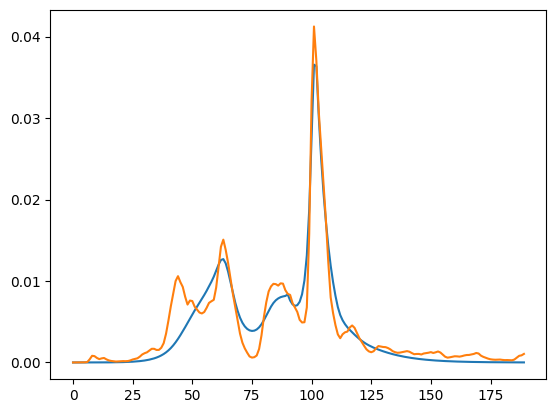

In [40]:
Sc, Ic, tc = SIRmodel(S0,I0,beta,gamma,N,1)
plt.plot(tc[:nd],Ic[:nd].detach(),tc[:nd],Iobs)


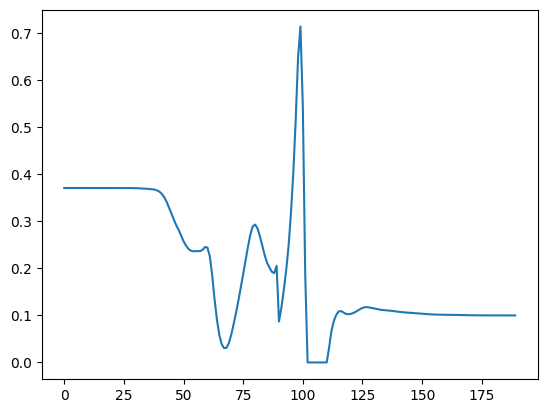

In [41]:
plt.plot(beta.detach())

**Fitting multiple citties at the same time**

Assume that we want to fit all Canada at the same time.
We can pull all data from all provices and fit them together.

To this end we need to assume that the interaction between provinces is modelled. We use the graph Laplacian for this.

Our midterm project is to do that in order to fit the data.
You should be able to do this and find parameters for this model.

In [ ]:
print(b)